## **Setup**

In [3]:
!pip install yfinance optuna tensorflow joblib optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.5 MB/s eta 0:00:00


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import TFKerasPruningCallback
import time
import os
import joblib
import random
import tensorflow as tf

In [7]:
# Set seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'

## **Data**

In [8]:
from datetime import datetime

def get_crypto_data(symbol='BTC-USD', start='2020-01-01'):
    end = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(symbol, start=start, end=end, auto_adjust=False)
    df = df[['Close']].dropna()
    return df

data = get_crypto_data('BTC-USD', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [9]:
data.head()

Price,Close
Ticker,BTC-USD
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


In [11]:
data.describe()

Price,Close
Ticker,BTC-USD
count,2121.000000
mean,45589.979373
std,30627.375852
min,4970.788086
25%,21395.019531
50%,38469.093750
75%,62678.292969
max,124752.531250


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2121 entries, 2020-01-01 to 2025-10-21
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BTC-USD)  2121 non-null   float64
dtypes: float64(1)
memory usage: 33.1 KB


## **Preprocessing**

In [13]:
def normalize_series(series):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)
    return scaled, scaler

def create_sequences(data, window_size=14):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

## **Rolling Window**

In [15]:
def rolling_window_split(data, window_size=14):
    folds = [
        ("2020-01-01", "2023-10-31", "2023-11-01", "2023-12-31"),  # Bear Market (2022-2023)
        ("2024-01-01", "2025-07-31", "2025-08-01", "2025-09-30")   # Bull Market (2024-2025)
    ]
    splits = []
    for t_start, t_end, te_start, te_end in folds:
        if pd.to_datetime(te_start) > data.index[-1]:
            continue
        train = data.loc[t_start:t_end]
        test = data.loc[te_start:te_end]
        if len(train) == 0 or len(test) == 0:
            continue
        train_scaled, scaler = normalize_series(train)
        test_scaled = scaler.transform(test)
        X_train, y_train = create_sequences(train_scaled, window_size)
        X_test, y_test = create_sequences(test_scaled, window_size)
        splits.append((X_train, y_train, X_test, y_test, scaler, (t_start, t_end, te_start, te_end)))
    return splits

## **Model**

In [16]:
def build_lstm_model(trial, input_shape):
    model = Sequential()
    model.add(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        activation='relu',
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2]),
        input_shape=input_shape
    ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_bilstm_model(trial, input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        activation='relu',
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2])
    ), input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_cnn_lstm_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2])
    ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_cnn_bilstm_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Bidirectional(LSTM(
        units=trial.suggest_categorical("units", [32, 64]),
        dropout=trial.suggest_categorical("dropout", [0.1, 0.2])
    )))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## **Metrics**

In [17]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    da = np.mean((np.sign(np.diff(y_true.flatten())) == np.sign(np.diff(y_pred.flatten()))).astype(int))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape, da

## **Optuna**

In [21]:
def optimize_model(X_train_opt, y_train_opt, X_val, y_val, build_fn, n_trials=20):
    def objective(trial):
        model = build_fn(trial, (X_train_opt.shape[1], X_train_opt.shape[2]))
        es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
        model.fit(
            X_train_opt, y_train_opt,
            validation_data=(X_val, y_val),
            epochs=trial.suggest_categorical("epochs", [100, 200]),
            batch_size=trial.suggest_categorical("batch_size", [32, 64]),
            verbose=0,
            callbacks=[es, TFKerasPruningCallback(trial, "val_loss")]
        )
        val_pred = model.predict(X_val, verbose=0)
        return mean_squared_error(y_val, val_pred)
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

## **Pipeline**

In [22]:
def run_experiment(window_size, n_trials=20):
    print(f"\n{'='*70}")
    print(f" RUNNING EXPERIMENT: WINDOW SIZE = {window_size} ")
    print(f"{'='*70}")

    # Create splits for this window size
    splits = rolling_window_split(data, window_size)
    if not splits:
        print("  → No valid splits. Skipping.")
        return None, None

    model_builders = {
        'LSTM': build_lstm_model,
        'BiLSTM': build_bilstm_model,
        'CNN-LSTM': build_cnn_lstm_model,
        'CNN-BiLSTM': build_cnn_bilstm_model
    }

    results = {}
    timing_results = {}
    VAL_DAYS = 60  # Keep validation consistent

    for model_name, builder in model_builders.items():
        results[model_name] = []
        timing_results[model_name] = []

        for fold_idx, (X_train, y_train, X_test, y_test, scaler, dates) in enumerate(splits):
            t_start, t_end, te_start, te_end = dates
            print(f"[{model_name}] Fold {fold_idx+1} | Win={window_size}")

            if len(X_train) <= VAL_DAYS:
                print(f"  → Skip: not enough data ({len(X_train)})")
                continue

            # Temporal validation
            X_train_opt = X_train[:-VAL_DAYS]
            y_train_opt = y_train[:-VAL_DAYS]
            X_val = X_train[-VAL_DAYS:]
            y_val = y_train[-VAL_DAYS:]

            # Optuna tuning
            study = optimize_model(X_train_opt, y_train_opt, X_val, y_val, builder, n_trials=n_trials)

            # Retrain best model
            best_model = builder(study.best_trial, (X_train.shape[1], X_train.shape[2]))
            best_model.fit(
                X_train, y_train,
                epochs=study.best_trial.params['epochs'],
                batch_size=study.best_trial.params['batch_size'],
                verbose=0
            )

            # Predict & evaluate
            pred = best_model.predict(X_test, verbose=0)
            y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
            pred_inv = scaler.inverse_transform(pred)
            mae, rmse, mape, da = calculate_metrics(y_test_inv, pred_inv)

            # Save model & scaler with window size
            model_path = f"{model_name}_fold_{fold_idx+1}_win{window_size}.keras"
            scaler_path = f"{model_name}_fold_{fold_idx+1}_win{window_size}_scaler.pkl"
            best_model.save(model_path)
            joblib.dump(scaler, scaler_path)

            # Store results (including predictions for plotting)
            test_dates = data.loc[te_start:te_end].index[window_size:]
            results[model_name].append({
                'Window_Size': window_size,
                'Fold': fold_idx + 1,
                'Test_Dates': test_dates,
                'Actual': y_test_inv,
                'Predictions': pred_inv,
                'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'DA': da,
                'Best Params': study.best_trial.params
            })

    return results, splits

In [23]:
window_sizes = [7, 14, 21]  # Add more if needed
all_results = {}

for ws in window_sizes:
    results, splits = run_experiment(window_size=ws, n_trials=10)  # Reduce trials for speed
    if results:
        all_results[ws] = results

# Save all results to disk (optional but recommended)
import pickle
with open('window_size_experiment_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

[I 2025-10-23 04:44:55,598] A new study created in memory with name: no-name-144eee60-68d3-45c7-9822-3cab227f07ec



 RUNNING EXPERIMENT: WINDOW SIZE = 7 
[LSTM] Fold 1 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:00,528] Trial 0 finished with value: 0.0008054606125167738 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0008054606125167738.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:04,744] Trial 1 finished with value: 0.0005044943514574479 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0005044943514574479.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:10,960] Trial 2 finished with value: 0.0010739467399799535 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0005044943514574479.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:15,986] Trial 3 finished with value: 0.0006455016775141107 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0005044943514574479.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:20,302] Trial 4 finished with value: 0.0008955463133025037 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0005044943514574479.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:23,491] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:45:27,912] Trial 6 finished with value: 0.000685685712132533 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0005044943514574479.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:45:30,960] Trial 7 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 04:45:33,614] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:45:37,352] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 04:46:17,546] A new study created in memory with name: no-name-d41673de-5510-45e1-9b6d-01b6af57316a


[LSTM] Fold 2 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:46:23,373] Trial 0 finished with value: 0.005781154963160903 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.005781154963160903.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:46:27,799] Trial 1 finished with value: 0.009657054228466272 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.005781154963160903.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:46:33,343] Trial 2 finished with value: 0.00642115043803041 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.005781154963160903.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:46:38,190] Trial 3 finished with value: 0.03252422205652908 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.005781154963160903.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:46:42,101] Trial 4 finished with value: 0.03486721787448543 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.005781154963160903.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:46:44,421] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:46:48,949] Trial 6 pruned. Trial was pruned at epoch 4.
[I 2025-10-23 04:46:51,651] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:46:58,317] Trial 8 finished with value: 0.00454650471221943 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 8 with value: 0.00454650471221943.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:47:01,150] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 04:47:31,821] A new study created in memory with name: no-name-e1bb80d6-cd98-4f70-853c-690840d92a6d


[BiLSTM] Fold 1 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:47:39,115] Trial 0 finished with value: 0.000649502653571148 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.000649502653571148.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:47:45,525] Trial 1 finished with value: 0.0010680108949274413 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.000649502653571148.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:47:53,321] Trial 2 finished with value: 0.0007257518376775585 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.000649502653571148.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:48:01,231] Trial 3 finished with value: 0.0018729266178178607 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.000649502653571148.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:48:09,058] Trial 4 finished with value: 0.002187369892486452 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.000649502653571148.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:48:12,949] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:48:18,054] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:48:22,033] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:48:25,943] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:48:30,478] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 04:49:15,617] A new study created in memory with name: no-name-864ed5ca-451e-4582-b365-38f4d694c65c


[BiLSTM] Fold 2 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:49:22,226] Trial 0 finished with value: 0.001036193187593982 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.001036193187593982.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:49:29,281] Trial 1 finished with value: 0.004128516249648163 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.001036193187593982.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:49:35,617] Trial 2 finished with value: 0.001135716752910076 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.001036193187593982.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:49:41,446] Trial 3 finished with value: 0.012751206161811822 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.001036193187593982.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:49:47,683] Trial 4 finished with value: 0.011935060849038701 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.001036193187593982.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:49:51,477] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:49:55,777] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:49:59,958] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:50:05,392] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:50:10,028] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 04:50:27,945] A new study created in memory with name: no-name-938a03b6-e167-414d-8e97-c13b5d8248e1


[CNN-LSTM] Fold 1 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:50:35,864] Trial 0 finished with value: 0.00026198109858094484 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.00026198109858094484.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:50:41,103] Trial 1 finished with value: 0.00028701649776049224 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.00026198109858094484.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:50:49,070] Trial 2 finished with value: 0.00032506934499339305 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00026198109858094484.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:51:01,159] Trial 3 finished with value: 0.0001585297789376985 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.0001585297789376985.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:51:05,831] Trial 4 finished with value: 0.00027859203097033543 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0001585297789376985.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:51:08,755] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:51:12,355] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:51:15,241] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:51:18,221] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:51:21,450] Trial 9 pruned. Trial was pruned at epoch 1.


[I 2025-10-23 04:52:23,815] A new study created in memory with name: no-name-7d7782d3-17ce-4973-bf5e-8c6aa7a55291


[CNN-LSTM] Fold 2 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:52:29,288] Trial 0 finished with value: 0.00150647088591947 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00150647088591947.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:52:34,773] Trial 1 finished with value: 0.0018565045533974016 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.00150647088591947.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:52:40,397] Trial 2 finished with value: 0.001933678605904575 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.00150647088591947.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:52:45,647] Trial 3 finished with value: 0.0019426710167061193 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00150647088591947.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:52:50,656] Trial 4 finished with value: 0.0016682130400739767 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.00150647088591947.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:52:53,954] Trial 5 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 04:52:58,236] Trial 6 finished with value: 0.0012770615020787858 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 6 with value: 0.0012770615020787858.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:53:03,917] Trial 7 finished with value: 0.0012052507854238793 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 7 with value: 0.0012052507854238793.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:53:07,042] Trial 8 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 04:53:10,201] Trial 9 pruned. Trial was pruned at epoch 2.


[I 2025-10-23 04:53:42,701] A new study created in memory with name: no-name-b0ca1415-45cd-487e-a6d0-4445229fa22d


[CNN-BiLSTM] Fold 1 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:53:51,239] Trial 0 finished with value: 0.00035605912319690525 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00035605912319690525.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:53:59,478] Trial 1 finished with value: 0.0003794430118979499 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.00035605912319690525.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:54:10,090] Trial 2 finished with value: 0.00035967964569041494 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.00035605912319690525.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:54:20,474] Trial 3 finished with value: 0.00020849110340548274 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.00020849110340548274.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:54:35,119] Trial 4 finished with value: 0.00023120139461537943 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.00020849110340548274.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:54:39,801] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:54:45,038] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:54:49,580] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:54:58,614] Trial 8 finished with value: 0.0003516546449735289 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.00020849110340548274.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:55:18,845] Trial 9 finished with value: 0.00010048072913599822 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 9 with value: 0.00010048072913599822.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-10-23 04:56:06,479] A new study created in memory with name: no-name-826152f7-1c8b-4c72-8634-2b13bd47e255


[CNN-BiLSTM] Fold 2 | Win=7


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:56:14,185] Trial 0 finished with value: 0.0014379737025511552 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0014379737025511552.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:56:22,147] Trial 1 finished with value: 0.0011175921774320115 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0011175921774320115.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:56:32,791] Trial 2 finished with value: 0.0008517487060556772 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.0008517487060556772.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:56:43,305] Trial 3 finished with value: 0.0012589128802259042 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.0008517487060556772.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:56:51,903] Trial 4 finished with value: 0.001082934900937081 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 0.0008517487060556772.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 04:57:00,940] Trial 5 pruned. Trial was pruned at epoch 16.
[I 2025-10-23 04:57:05,442] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:57:10,889] Trial 7 pruned. Trial was pruned at epoch 4.
[I 2025-10-23 04:57:16,051] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 04:57:20,628] Trial 9 pruned. Trial was pruned at epoch 1.


[I 2025-10-23 04:58:04,842] A new study created in memory with name: no-name-aa50257f-83b3-43c9-95ed-5e5bb7e92211



 RUNNING EXPERIMENT: WINDOW SIZE = 14 
[LSTM] Fold 1 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:10,164] Trial 0 finished with value: 0.0024438072201409043 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0024438072201409043.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:16,479] Trial 1 finished with value: 0.0016334111560878867 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0016334111560878867.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:20,957] Trial 2 finished with value: 0.0010216412546615076 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.0010216412546615076.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:27,606] Trial 3 finished with value: 0.0017152110559359617 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.0010216412546615076.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:33,043] Trial 4 finished with value: 0.0015939912759802418 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0010216412546615076.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:37,373] Trial 5 finished with value: 0.0008107160344199345 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 5 with value: 0.0008107160344199345.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:43,157] Trial 6 finished with value: 0.0011228070319735995 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0008107160344199345.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:58:45,546] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 04:58:48,507] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 04:58:55,164] Trial 9 finished with value: 0.0011901229750133303 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0008107160344199345.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-10-23 04:59:25,611] A new study created in memory with name: no-name-bbce2af5-62c1-4a3b-b7cd-3849a6d7153b


[LSTM] Fold 2 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:33,267] Trial 0 finished with value: 0.01796383088407321 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.01796383088407321.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:37,554] Trial 1 finished with value: 0.0341653113767079 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.01796383088407321.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:42,732] Trial 2 finished with value: 0.004014571148364359 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.004014571148364359.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:46,617] Trial 3 finished with value: 0.0031274795226563174 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0031274795226563174.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:50,634] Trial 4 finished with value: 0.0024185496012128203 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 4 with value: 0.0024185496012128203.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:55,920] Trial 5 finished with value: 0.0037455100666796666 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 4 with value: 0.0024185496012128203.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 04:59:59,008] Trial 6 pruned. Trial was pruned at epoch 3.
[I 2025-10-23 05:00:01,440] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:00:03,839] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:00:07,002] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:00:20,816] A new study created in memory with name: no-name-aaa0c547-94eb-4aec-b938-dbf901ba9989


[BiLSTM] Fold 1 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:00:27,466] Trial 0 finished with value: 0.0010482474753591535 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0010482474753591535.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:00:35,254] Trial 1 finished with value: 0.0015534005738951327 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0010482474753591535.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:00:42,332] Trial 2 finished with value: 0.0008080233221247951 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.0008080233221247951.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:00:50,393] Trial 3 finished with value: 0.0012572627335471407 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0008080233221247951.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:00:58,220] Trial 4 finished with value: 0.0011003624802249572 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.0008080233221247951.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:01:02,108] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:01:07,172] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:01:15,397] Trial 7 finished with value: 0.001532644402115635 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0008080233221247951.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:01:28,951] Trial 8 finished with value: 0.0009292333562130412 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0008080233221247951.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:01:38,811] Trial 9 pruned. Trial was pruned at epoch 8.


[I 2025-10-23 05:02:47,177] A new study created in memory with name: no-name-e600da80-cf59-4898-bb59-b24d7ef835e5


[BiLSTM] Fold 2 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:02:53,534] Trial 0 finished with value: 0.016565727496426305 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.016565727496426305.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:03:04,354] Trial 1 finished with value: 0.01250387079902229 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.01250387079902229.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:03:11,029] Trial 2 finished with value: 0.0017787663990563697 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0017787663990563697.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:03:17,942] Trial 3 finished with value: 0.007792223986071534 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 0.0017787663990563697.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:03:25,329] Trial 4 finished with value: 0.0017025391033276985 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.0017025391033276985.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:03:29,669] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:03:33,904] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:03:38,495] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:03:44,655] Trial 8 finished with value: 0.0027401594406650464 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.0017025391033276985.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:03:48,883] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:04:21,695] A new study created in memory with name: no-name-c245d8bb-8827-4617-8a9d-f6b98592ae29


[CNN-LSTM] Fold 1 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:04:28,777] Trial 0 finished with value: 0.00044461543889991255 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.00044461543889991255.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:04:39,363] Trial 1 finished with value: 0.0003619984404013033 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0003619984404013033.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:04:44,382] Trial 2 finished with value: 0.00044495455504492236 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0003619984404013033.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:04:56,471] Trial 3 finished with value: 0.0002633318812027923 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 3 with value: 0.0002633318812027923.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:05:06,249] Trial 4 finished with value: 0.00028655012900989527 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.0002633318812027923.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:05:10,040] Trial 5 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 05:05:14,176] Trial 6 pruned. Trial was pruned at epoch 3.
[I 2025-10-23 05:05:18,340] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:05:22,672] Trial 8 pruned. Trial was pruned at epoch 3.
[I 2025-10-23 05:05:25,655] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:06:04,377] A new study created in memory with name: no-name-da6aa5f6-20f8-4318-8ac2-290e271e89f6


[CNN-LSTM] Fold 2 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:09,379] Trial 0 finished with value: 0.0015958626040608714 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0015958626040608714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:14,814] Trial 1 finished with value: 0.0017217167063788836 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0015958626040608714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:20,242] Trial 2 finished with value: 0.0020465581772751316 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0015958626040608714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:26,977] Trial 3 finished with value: 0.0017692128381675818 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0015958626040608714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:34,028] Trial 4 finished with value: 0.0019390467561068078 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0015958626040608714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:38,439] Trial 5 finished with value: 0.0017988649742655554 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.0015958626040608714.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:41,320] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:06:49,515] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:06:55,529] Trial 8 finished with value: 0.0012241045308701184 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 8 with value: 0.0012241045308701184.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:06:58,892] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:07:37,890] A new study created in memory with name: no-name-61560b39-723f-464c-bd8c-4516bdcaae1f


[CNN-BiLSTM] Fold 1 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:07:54,267] Trial 0 finished with value: 0.0002943267920446299 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0002943267920446299.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:08:25,933] Trial 1 finished with value: 0.0001622359507623483 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0001622359507623483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:08:42,533] Trial 2 finished with value: 0.0003311343562332997 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0001622359507623483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:09:05,117] Trial 3 finished with value: 0.0003653233640043971 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0001622359507623483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:09:15,004] Trial 4 finished with value: 0.0007652259906693841 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.0001622359507623483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:09:32,476] Trial 5 finished with value: 0.0002410960367531234 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.0001622359507623483.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:09:37,527] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:09:49,101] Trial 7 pruned. Trial was pruned at epoch 11.
[I 2025-10-23 05:10:10,537] Trial 8 finished with value: 0.0001522995265516229 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 8 with value: 0.0001522995265516229.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:10:15,700] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:12:39,530] A new study created in memory with name: no-name-f17cf1ad-5805-4c3f-a62a-76173b824674


[CNN-BiLSTM] Fold 2 | Win=14


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:12:47,869] Trial 0 finished with value: 0.0016133326530840173 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:12:56,608] Trial 1 finished with value: 0.0017422963465097536 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:13:04,817] Trial 2 finished with value: 0.0025090291201669366 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:13:14,258] Trial 3 finished with value: 0.0018047626224828343 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:13:22,093] Trial 4 finished with value: 0.0023197594026099114 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:13:29,920] Trial 5 finished with value: 0.0018998603873800043 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:13:34,632] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:13:40,246] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:13:53,125] Trial 8 finished with value: 0.0017649513657691193 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0016133326530840173.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:13:59,089] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:14:24,244] A new study created in memory with name: no-name-b272b196-9c54-4961-94ec-2e368f9a8ac5



 RUNNING EXPERIMENT: WINDOW SIZE = 21 
[LSTM] Fold 1 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:14:31,067] Trial 0 finished with value: 0.0018127844247270983 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0018127844247270983.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:14:37,614] Trial 1 finished with value: 0.0017725674578337907 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.0017725674578337907.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:14:46,840] Trial 2 finished with value: 0.0013146249695837361 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.0013146249695837361.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:14:52,908] Trial 3 finished with value: 0.00116718823210831 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.00116718823210831.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:14:59,680] Trial 4 finished with value: 0.0017067381339783841 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.00116718823210831.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:15:02,615] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:15:05,704] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:15:09,054] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:15:11,790] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:15:14,583] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:17:06,179] A new study created in memory with name: no-name-7cb0fdcb-ac56-4c80-a031-5e1daada2970


[LSTM] Fold 2 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:17:12,138] Trial 0 finished with value: 0.03941798487442621 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.03941798487442621.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:17:17,526] Trial 1 finished with value: 0.012984441050907403 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.012984441050907403.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:17:21,820] Trial 2 finished with value: 0.011619045583599967 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 0.011619045583599967.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:17:29,781] Trial 3 finished with value: 0.010620749518849481 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 3 with value: 0.010620749518849481.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:17:34,196] Trial 4 finished with value: 0.0016962145974460012 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 4 with value: 0.0016962145974460012.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:17:37,470] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:17:40,083] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:17:42,699] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:17:45,279] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:17:48,263] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:18:16,513] A new study created in memory with name: no-name-e45f7b4f-0a3f-43d4-b1da-875b80c0d36f


[BiLSTM] Fold 1 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:18:23,438] Trial 0 finished with value: 0.0017728309914661956 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0017728309914661956.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:18:33,154] Trial 1 finished with value: 0.003597429762107947 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0017728309914661956.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:18:43,336] Trial 2 finished with value: 0.0012386116257192472 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.0012386116257192472.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:18:52,549] Trial 3 finished with value: 0.0016039162730200386 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 0.0012386116257192472.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:19:04,161] Trial 4 finished with value: 0.0020284647679335104 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0012386116257192472.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:19:14,820] Trial 5 finished with value: 0.0009269494048661218 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 5 with value: 0.0009269494048661218.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:19:19,748] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:19:32,329] Trial 7 finished with value: 0.0011508122296963001 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0009269494048661218.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:19:45,497] Trial 8 finished with value: 0.0011271444824625218 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 5 with value: 0.0009269494048661218.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:19:49,906] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:21:40,782] A new study created in memory with name: no-name-34f099ae-dfb4-476d-a403-ae719ca6b59c


[BiLSTM] Fold 2 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:21:51,808] Trial 0 finished with value: 0.008086504063370574 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.008086504063370574.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:21:58,147] Trial 1 finished with value: 0.0031376414836381404 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0031376414836381404.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:22:05,224] Trial 2 finished with value: 0.003133124991632868 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.003133124991632868.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:22:13,217] Trial 3 finished with value: 0.00831832509509033 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.003133124991632868.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:22:30,236] Trial 4 finished with value: 0.001748766286493997 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 4 with value: 0.001748766286493997.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-10-23 05:22:34,776] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:22:40,082] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:22:45,287] Trial 7 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 05:22:49,692] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:22:54,632] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:23:20,967] A new study created in memory with name: no-name-77794fe6-2057-4140-9742-b7811a2aac02


[CNN-LSTM] Fold 1 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:23:34,097] Trial 0 finished with value: 0.0002901806959728406 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 0 with value: 0.0002901806959728406.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:23:42,276] Trial 1 finished with value: 0.0005311463256296205 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.0002901806959728406.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:24:00,665] Trial 2 finished with value: 0.0001994314719416121 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.0001994314719416121.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:24:18,113] Trial 3 finished with value: 0.00019868698482684768 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.00019868698482684768.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:24:32,667] Trial 4 finished with value: 0.00020554701098470516 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.00019868698482684768.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:24:38,205] Trial 5 pruned. Trial was pruned at epoch 3.
[I 2025-10-23 05:24:41,768] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:24:47,256] Trial 7 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 05:24:50,402] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:24:54,014] Trial 9 pruned. Trial was pruned at epoch 1.


[I 2025-10-23 05:27:08,239] A new study created in memory with name: no-name-4295b970-f7a7-47af-bfef-cfb2d46764bd


[CNN-LSTM] Fold 2 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:27:12,915] Trial 0 finished with value: 0.004026366617339241 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.004026366617339241.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:27:18,724] Trial 1 finished with value: 0.002044228552826753 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 1 with value: 0.002044228552826753.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:27:23,464] Trial 2 finished with value: 0.0020503221397484106 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 1 with value: 0.002044228552826753.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:27:31,682] Trial 3 finished with value: 0.006619249634488911 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 1 with value: 0.002044228552826753.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:27:37,295] Trial 4 finished with value: 0.0017360791523476156 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 4 with value: 0.0017360791523476156.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:27:41,141] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:27:44,171] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:27:47,157] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:27:50,353] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:27:54,408] Trial 9 pruned. Trial was pruned at epoch 1.


[I 2025-10-23 05:28:14,725] A new study created in memory with name: no-name-19bb7ae6-6a3b-4e40-9829-bcb82662969b


[CNN-BiLSTM] Fold 1 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:28:26,464] Trial 0 finished with value: 0.0009415735299156456 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 0 with value: 0.0009415735299156456.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:28:48,034] Trial 1 finished with value: 0.0002472254908872894 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 0.0002472254908872894.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:29:16,739] Trial 2 finished with value: 0.00017462814111579027 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.00017462814111579027.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:29:31,757] Trial 3 finished with value: 0.0006983634681759352 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.00017462814111579027.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:30:04,723] Trial 4 finished with value: 0.0001741553758301605 and parameters: {'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}. Best is trial 4 with value: 0.0001741553758301605.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:30:18,333] Trial 5 pruned. Trial was pruned at epoch 7.
[I 2025-10-23 05:30:26,515] Trial 6 pruned. Trial was pruned at epoch 2.
[I 2025-10-23 05:30:31,448] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:30:42,944] Trial 8 pruned. Trial was pruned at epoch 5.
[I 2025-10-23 05:30:47,847] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2025-10-23 05:33:05,022] A new study created in memory with name: no-name-7e7efb88-b636-4f8b-a27e-5c361ca88ff4


[CNN-BiLSTM] Fold 2 | Win=21


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:33:21,949] Trial 0 finished with value: 0.003287356926033634 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 0.003287356926033634.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:33:33,496] Trial 1 finished with value: 0.005445683829325382 and parameters: {'units': 32, 'dropout': 0.2, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 0.003287356926033634.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:33:44,734] Trial 2 finished with value: 0.0028267591121455505 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.0028267591121455505.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:33:53,200] Trial 3 finished with value: 0.002791661930439476 and parameters: {'units': 32, 'dropout': 0.1, 'epochs': 100, 'batch_size': 64}. Best is trial 3 with value: 0.002791661930439476.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:34:05,292] Trial 4 finished with value: 0.002509994616778143 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 32}. Best is trial 4 with value: 0.002509994616778143.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:34:10,961] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:34:19,613] Trial 6 finished with value: 0.002433773677712453 and parameters: {'units': 64, 'dropout': 0.2, 'epochs': 200, 'batch_size': 64}. Best is trial 6 with value: 0.002433773677712453.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-10-23 05:34:25,366] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2025-10-23 05:34:30,607] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2025-10-23 05:34:36,944] Trial 9 pruned. Trial was pruned at epoch 1.


## **Comparison**

In [29]:
# Get model evaluation
model_evaluation = []
for ws, results in all_results.items():
    for model_name, folds in results.items():
        for fold_idx, fold_results in enumerate(folds):
            model_evaluation.append({
                'Window_Size': ws,
                'Model': model_name,
                'Fold': fold_idx + 1,
                'MAE': fold_results['MAE'],
                'RMSE': fold_results['RMSE'],
                'MAPE': fold_results['MAPE'],
                'DA': fold_results['DA']
            })

df_eval = pd.DataFrame(model_evaluation)
print(df_eval)

    Window_Size       Model  Fold           MAE          RMSE       MAPE  \
0             7        LSTM     1   3376.049913   3494.471941   8.374878   
1             7        LSTM     2   7173.568142   7384.559136   6.281647   
2             7      BiLSTM     1   4384.401403   4486.945757  10.861986   
3             7      BiLSTM     2  14273.361690  14403.569434  12.504340   
4             7    CNN-LSTM     1   3383.598416   3504.410763   8.390274   
5             7    CNN-LSTM     2  13497.226997  13614.440307  11.825564   
6             7  CNN-BiLSTM     1   1918.496238   2098.213113   4.745426   
7             7  CNN-BiLSTM     2   4153.827980   4537.658633   3.621065   
8            14        LSTM     1   6691.399892   6765.424619  16.396506   
9            14        LSTM     2   6257.658078   6611.912627   5.505935   
10           14      BiLSTM     1   3520.497008   3635.467273   8.624081   
11           14      BiLSTM     2   7327.758311   7538.342683   6.462095   
12          

In [30]:
# Get model best paramas
model_params = []
for ws, results in all_results.items():
    for model_name, folds in results.items():
        for fold_idx, fold_results in enumerate(folds):
            model_params.append({
                'Window_Size': ws,
                'Model': model_name,
                'Fold': fold_idx + 1,
                'Best Params': fold_results['Best Params']
            })

df_params = pd.DataFrame(model_params)
print(df_params)

    Window_Size       Model  Fold  \
0             7        LSTM     1   
1             7        LSTM     2   
2             7      BiLSTM     1   
3             7      BiLSTM     2   
4             7    CNN-LSTM     1   
5             7    CNN-LSTM     2   
6             7  CNN-BiLSTM     1   
7             7  CNN-BiLSTM     2   
8            14        LSTM     1   
9            14        LSTM     2   
10           14      BiLSTM     1   
11           14      BiLSTM     2   
12           14    CNN-LSTM     1   
13           14    CNN-LSTM     2   
14           14  CNN-BiLSTM     1   
15           14  CNN-BiLSTM     2   
16           21        LSTM     1   
17           21        LSTM     2   
18           21      BiLSTM     1   
19           21      BiLSTM     2   
20           21    CNN-LSTM     1   
21           21    CNN-LSTM     2   
22           21  CNN-BiLSTM     1   
23           21  CNN-BiLSTM     2   

                                          Best Params  
0   {'units': 64, 

In [31]:
# Check detail params
df_params['Best Params'].iloc[0]

{'units': 64, 'dropout': 0.1, 'epochs': 200, 'batch_size': 64}

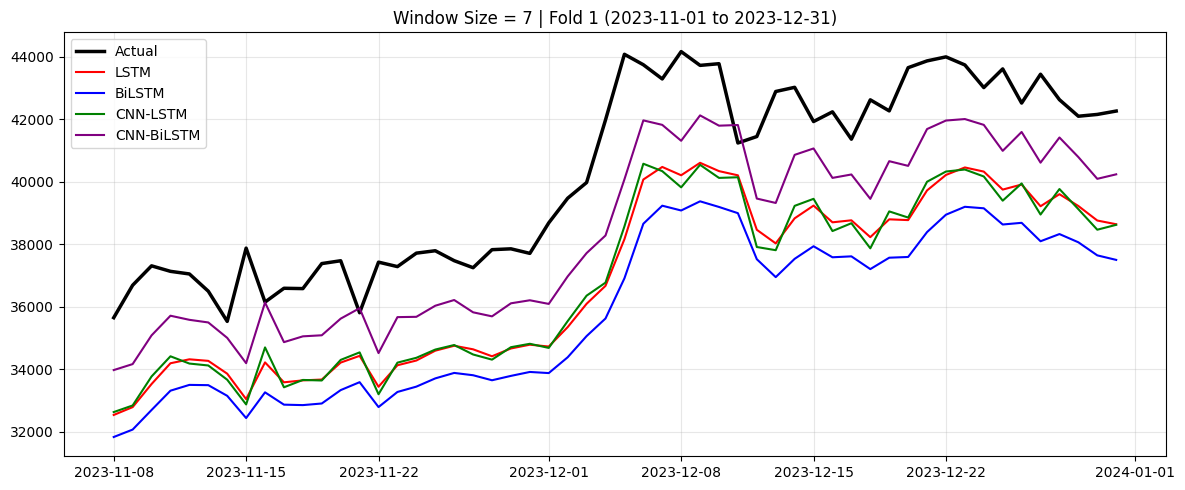

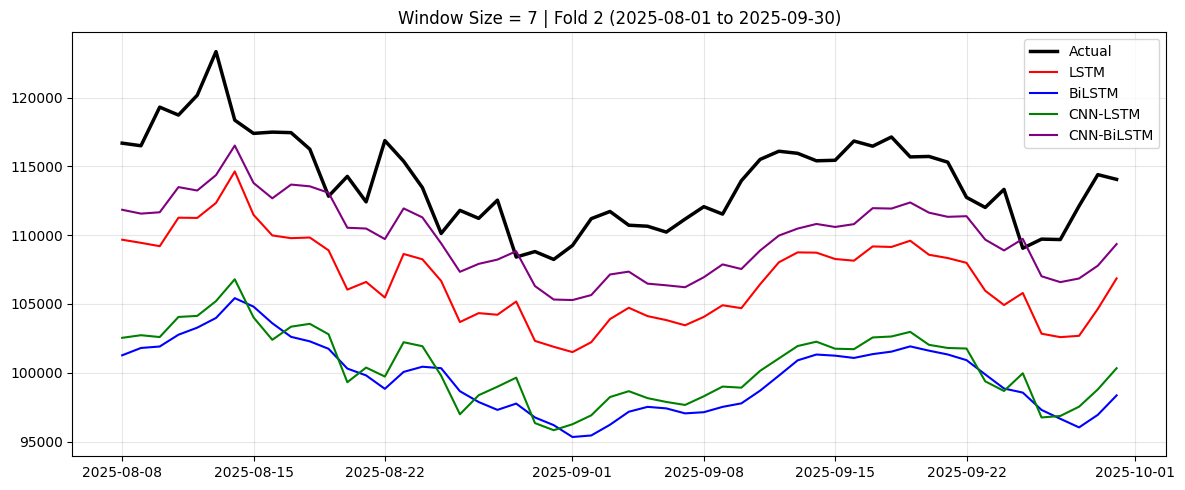

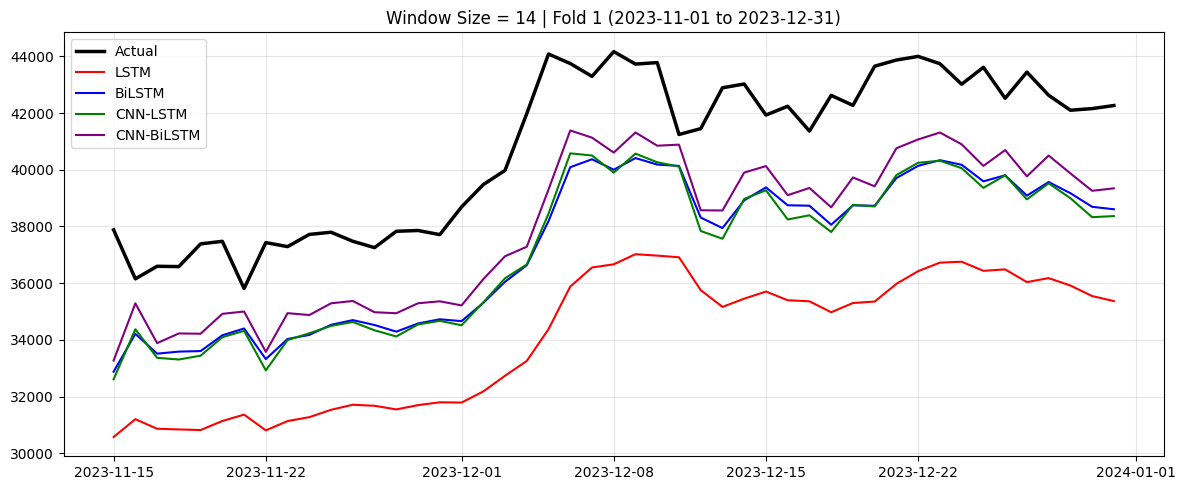

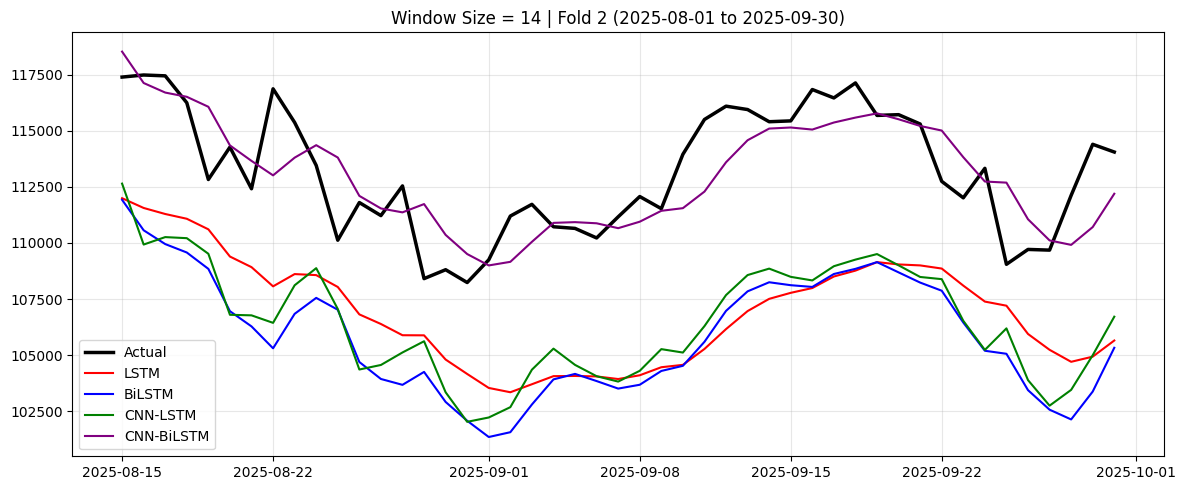

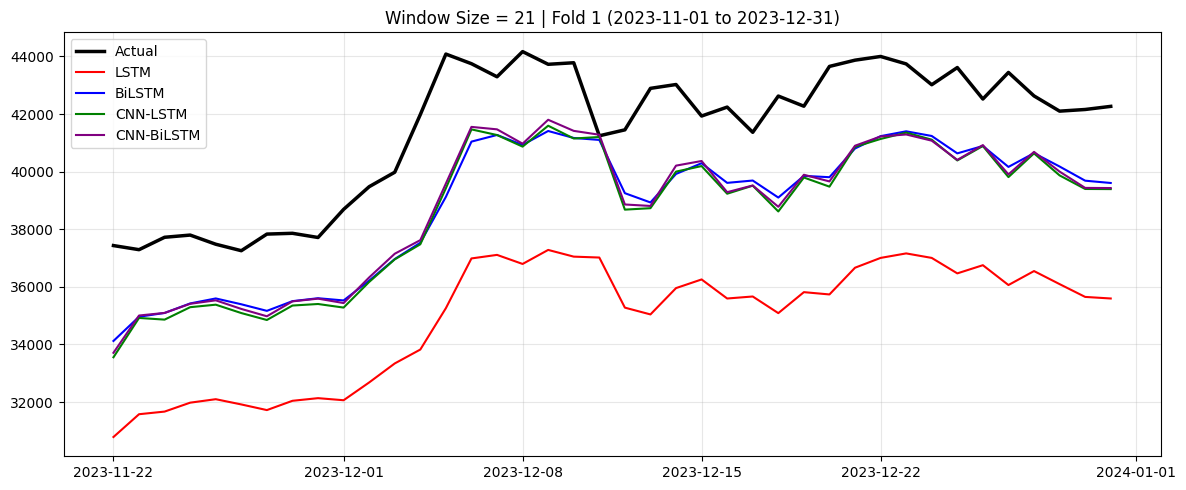

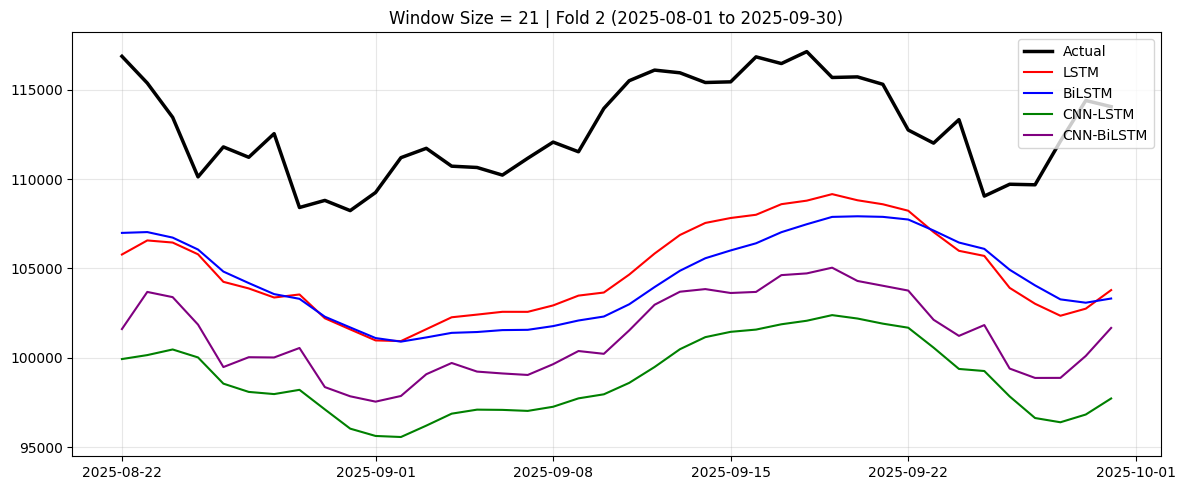

In [25]:
# Plot actual vs predictions for each window size
for ws, results in all_results.items():
    splits_ws = rolling_window_split(data, ws)  # Re-generate splits for dates
    for fold_idx in range(len(splits_ws)):
        _, _, _, _, _, dates = splits_ws[fold_idx]
        _, _, te_start, te_end = dates

        plt.figure(figsize=(12, 5))
        # Actual prices
        y_actual = data.loc[te_start:te_end]['Close'].values[ws:]
        test_dates = data.loc[te_start:te_end].index[ws:]
        plt.plot(test_dates, y_actual, 'k-', linewidth=2.5, label='Actual')

        colors = {'LSTM': 'red', 'BiLSTM': 'blue', 'CNN-LSTM': 'green', 'CNN-BiLSTM': 'purple'}
        for model_name in results.keys():
            if fold_idx < len(results[model_name]):
                pred = results[model_name][fold_idx]['Predictions']
                plt.plot(test_dates, pred, color=colors[model_name], label=model_name)

        plt.title(f'Window Size = {ws} | Fold {fold_idx+1} ({te_start} to {te_end})')
        plt.legend(); plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()